In [1]:
# -----------------------------------------------------------------------------
# this runs the Cape Cod site flow case for the Harvey and Garabedian bacterial
# injection experiment from Maxwell, et al, 2007.
# -----------------------------------------------------------------------------

import os, sys
from set_demo_defaults import *

import matplotlib.pyplot as plt
from parflow import Run
from parflow.tools.fs import cp, chdir, mkdir, get_absolute_path, rm
from parflow.tools.io import read_pfb, write_pfb, ParflowBinaryReader
from parflow.tools.compare import pf_test_file
from parflow.tools.hydrology import compute_hydraulic_head

run_name = "harvey_flow.1"

#hflow = Run(run_name, __file__)
hflow = Run(run_name)

# -----------------------------------------------------------------------------
# File input version number
# -----------------------------------------------------------------------------

hflow.FileVersion = 4

# -----------------------------------------------------------------------------
# Process Topology
# -----------------------------------------------------------------------------

hflow.Process.Topology.P = 1
hflow.Process.Topology.Q = 1
hflow.Process.Topology.R = 1

# -----------------------------------------------------------------------------
# Computational Grid
# -----------------------------------------------------------------------------

hflow.ComputationalGrid.Lower.X = 0.0
hflow.ComputationalGrid.Lower.Y = 0.0
hflow.ComputationalGrid.Lower.Z = 0.0

hflow.ComputationalGrid.DX = 0.34
hflow.ComputationalGrid.DY = 0.34
hflow.ComputationalGrid.DZ = 0.038

hflow.ComputationalGrid.NX = 50
hflow.ComputationalGrid.NY = 1
hflow.ComputationalGrid.NZ = 100

# -----------------------------------------------------------------------------
# The Names of the GeomInputs
# -----------------------------------------------------------------------------

hflow.GeomInput.Names = "domain_input upper_aquifer_input"

# -----------------------------------------------------------------------------
# Domain Geometry Input
# -----------------------------------------------------------------------------

hflow.GeomInput.domain_input.InputType = "Box"
hflow.GeomInput.domain_input.GeomName = "domain"

# -----------------------------------------------------------------------------
# Domain Geometry
# -----------------------------------------------------------------------------

hflow.Geom.domain.Lower.X = 0.0
hflow.Geom.domain.Lower.Y = 0.0
hflow.Geom.domain.Lower.Z = 0.0

hflow.Geom.domain.Upper.X = 17.0
hflow.Geom.domain.Upper.Y = 10.2
hflow.Geom.domain.Upper.Z = 3.8

hflow.Geom.domain.Patches = "left right front back bottom top"

# -----------------------------------------------------------------------------
# Upper Aquifer Geometry Input
# -----------------------------------------------------------------------------

hflow.GeomInput.upper_aquifer_input.InputType = "Box"
hflow.GeomInput.upper_aquifer_input.GeomName = "upper_aquifer"

# -----------------------------------------------------------------------------
# Upper Aquifer Geometry
# -----------------------------------------------------------------------------

hflow.Geom.upper_aquifer.Lower.X = 0.0
hflow.Geom.upper_aquifer.Lower.Y = 0.0
hflow.Geom.upper_aquifer.Lower.Z = 0.0

hflow.Geom.upper_aquifer.Upper.X = 17.0
hflow.Geom.upper_aquifer.Upper.Y = 10.2
hflow.Geom.upper_aquifer.Upper.Z = 3.8

# -----------------------------------------------------------------------------
# Perm
# -----------------------------------------------------------------------------

hflow.Geom.Perm.Names = "upper_aquifer"

# we open a file, in this case from PEST to set upper and lower kg and sigma
#cp("$./stats4.txt")
chdir(".")

file = open("stats4.txt", "r")
lines = file.readlines()
kgu = float(lines[0])
varu = float(lines[1])
kgl = float(lines[2])
varl = float(lines[3])

## we use the parallel turning bands formulation in ParFlow to simulate
## GRF for upper and lower aquifer

hflow.Geom.upper_aquifer.Perm.Type = "TurnBands"
hflow.Geom.upper_aquifer.Perm.LambdaX = 3.60
hflow.Geom.upper_aquifer.Perm.LambdaY = 3.60
hflow.Geom.upper_aquifer.Perm.LambdaZ = 0.19
hflow.Geom.upper_aquifer.Perm.GeomMean = 112.00

hflow.Geom.upper_aquifer.Perm.Sigma = 1.0
hflow.Geom.upper_aquifer.Perm.Sigma = 0.48989794
hflow.Geom.upper_aquifer.Perm.NumLines = 150
hflow.Geom.upper_aquifer.Perm.RZeta = 5.0
hflow.Geom.upper_aquifer.Perm.KMax = 100.0000001
hflow.Geom.upper_aquifer.Perm.DelK = 0.2
hflow.Geom.upper_aquifer.Perm.Seed = 33333
hflow.Geom.upper_aquifer.Perm.LogNormal = "Log"
hflow.Geom.upper_aquifer.Perm.StratType = "Bottom"

# -----------------------------------------------------------------------------
# uncomment the lines below to run parallel gaussian instead
# of parallel turning bands

# hflow.Geom.upper_aquifer.Perm.Type = "ParGauss"

# hflow.Geom.upper_aquifer.Perm.Seed = 1
# hflow.Geom.upper_aquifer.Perm.MaxNPts = 70.0
# hflow.Geom.upper_aquifer.Perm.MaxCpts = 20


# pfset lower aqu and upper aq stats to pest/read in values
# -----------------------------------------------------------------------------

hflow.Geom.upper_aquifer.Perm.GeomMean = kgu
hflow.Geom.upper_aquifer.Perm.Sigma = varu


hflow.Perm.TensorType = "TensorByGeom"

hflow.Geom.Perm.TensorByGeom.Names = "domain"

hflow.Geom.domain.Perm.TensorValX = 1.0
hflow.Geom.domain.Perm.TensorValY = 1.0
hflow.Geom.domain.Perm.TensorValZ = 1.0

# -----------------------------------------------------------------------------
# Specific Storage
# -----------------------------------------------------------------------------
# specific storage does not figure into the impes (fully sat) case but we still
# need a key for it

hflow.SpecificStorage.Type = "Constant"
hflow.SpecificStorage.GeomNames = ""
hflow.Geom.domain.SpecificStorage.Value = 1.0e-4

# -----------------------------------------------------------------------------
# Phases
# -----------------------------------------------------------------------------

hflow.Phase.Names = "water"

hflow.Phase.water.Density.Type = "Constant"
hflow.Phase.water.Density.Value = 1.0

hflow.Phase.water.Viscosity.Type = "Constant"
hflow.Phase.water.Viscosity.Value = 1.0

# -----------------------------------------------------------------------------
# Contaminants
# -----------------------------------------------------------------------------

hflow.Contaminants.Names = ""

# -----------------------------------------------------------------------------
# Gravity
# -----------------------------------------------------------------------------

hflow.Gravity = 1.0

# -----------------------------------------------------------------------------
# Setup timing info
# -----------------------------------------------------------------------------

hflow.TimingInfo.BaseUnit = 1.0
hflow.TimingInfo.StartCount = -1
hflow.TimingInfo.StartTime = 0.0
hflow.TimingInfo.StopTime = 100.0
hflow.TimingInfo.DumpInterval = -1

# -----------------------------------------------------------------------------
# Porosity
# -----------------------------------------------------------------------------

hflow.Geom.Porosity.GeomNames = "domain"
hflow.Geom.domain.Porosity.Type = "Constant"
hflow.Geom.domain.Porosity.Value = 0.390

# -----------------------------------------------------------------------------
# Domain
# -----------------------------------------------------------------------------

hflow.Domain.GeomName = "domain"

# -----------------------------------------------------------------------------
# Mobility
# -----------------------------------------------------------------------------

hflow.Phase.water.Mobility.Type = "Constant"
hflow.Phase.water.Mobility.Value = 1.0

# -----------------------------------------------------------------------------
# Wells
# -----------------------------------------------------------------------------

hflow.Wells.Names = ""

# -----------------------------------------------------------------------------
# Time Cycles
# -----------------------------------------------------------------------------

hflow.Cycle.Names = "constant"
hflow.Cycle.constant.Names = "alltime"
hflow.Cycle.constant.alltime.Length = 1
hflow.Cycle.constant.Repeat = -1

# -----------------------------------------------------------------------------
# Boundary Conditions: Pressure
# -----------------------------------------------------------------------------

hflow.BCPressure.PatchNames = "left right front back bottom top"

hflow.Patch.left.BCPressure.Type = "DirEquilRefPatch"
hflow.Patch.left.BCPressure.Cycle = "constant"
hflow.Patch.left.BCPressure.RefGeom = "domain"
hflow.Patch.left.BCPressure.RefPatch = "bottom"
hflow.Patch.left.BCPressure.alltime.Value = 10.0

hflow.Patch.right.BCPressure.Type = "DirEquilRefPatch"
hflow.Patch.right.BCPressure.Cycle = "constant"
hflow.Patch.right.BCPressure.RefGeom = "domain"
hflow.Patch.right.BCPressure.RefPatch = "bottom"
hflow.Patch.right.BCPressure.alltime.Value = 9.97501

hflow.Patch.front.BCPressure.Type = "FluxConst"
hflow.Patch.front.BCPressure.Cycle = "constant"
hflow.Patch.front.BCPressure.alltime.Value = 0.0

hflow.Patch.back.BCPressure.Type = "FluxConst"
hflow.Patch.back.BCPressure.Cycle = "constant"
hflow.Patch.back.BCPressure.alltime.Value = 0.0

hflow.Patch.bottom.BCPressure.Type = "FluxConst"
hflow.Patch.bottom.BCPressure.Cycle = "constant"
hflow.Patch.bottom.BCPressure.alltime.Value = 0.0

hflow.Patch.top.BCPressure.Type = "FluxConst"
hflow.Patch.top.BCPressure.Cycle = "constant"
hflow.Patch.top.BCPressure.alltime.Value = 0.0

# ---------------------------------------------------------
# Topo slopes in x-direction
# ---------------------------------------------------------
# topo slopes do not figure into the impes (fully sat) case but we still
# need keys for them

hflow.TopoSlopesX.Type = "Constant"
hflow.TopoSlopesX.GeomNames = ""
hflow.TopoSlopesX.Geom.domain.Value = 0.0

# ---------------------------------------------------------
# Topo slopes in y-direction
# ---------------------------------------------------------

hflow.TopoSlopesY.Type = "Constant"
hflow.TopoSlopesY.GeomNames = ""

hflow.TopoSlopesY.Geom.domain.Value = 0.0

# ---------------------------------------------------------
# Mannings coefficient
# ---------------------------------------------------------
# mannings roughnesses do not figure into the impes (fully sat) case but we still
# need a key for them

hflow.Mannings.Type = "Constant"
hflow.Mannings.GeomNames = ""
hflow.Mannings.Geom.domain.Value = 0.0

# -----------------------------------------------------------------------------
# Phase sources:
# -----------------------------------------------------------------------------

hflow.PhaseSources.water.Type = "Constant"
hflow.PhaseSources.water.GeomNames = "domain"
hflow.PhaseSources.water.Geom.domain.Value = 0.0


#-----------------------------------------------------------------------------
# Time Cycles
#-----------------------------------------------------------------------------
hflow.Cycle.Names = 'constant'
hflow.Cycle.constant.Names = 'alltime'
hflow.Cycle.constant.alltime.Length = 1
hflow.Cycle.constant.Repeat = -1

# Writing output options for ParFlow
write_pfb = True  #only PFB output for water balance example
#  PFB  no SILO
hflow.Solver.PrintSubsurf             = True
hflow.Solver.PrintSubsurfData         = write_pfb
hflow.Solver.PrintPressure            = write_pfb
hflow.Solver.PrintSaturation          = write_pfb
hflow.Solver.PrintCLM                 = write_pfb
hflow.Solver.PrintMask                = write_pfb
hflow.Solver.PrintSpecificStorage     = write_pfb
hflow.Solver.PrintEvapTrans           = write_pfb
hflow.Solver.PrintVelocities          = True 

# -----------------------------------------------------------------------------
#  Solver Impes
# -----------------------------------------------------------------------------

hflow.Solver.MaxIter = 50
hflow.Solver.AbsTol = 1e-10
hflow.Solver.Drop = 1e-15

#-----------------------------------------------------------------------------
# Setup Timing
#-----------------------------------------------------------------------------
hflow.TimingInfo.BaseUnit     = 1.0
hflow.TimingInfo.StartCount   = 0
hflow.TimingInfo.StartTime    = 0.0
hflow.TimingInfo.StopTime     = 100.0
hflow.TimingInfo.DumpInterval = 1.0
hflow.TimeStep.Type           = 'Constant'
hflow.TimeStep.Value          = 1.0


# #-----------------------------------------------------------------------------
# # Set solver parameters
# #-----------------------------------------------------------------------------
# hflow.Solver         = 'Impes'
# hflow.Solver.MaxIter = 9000

# hflow.Solver.Nonlinear.MaxIter           = 100
# hflow.Solver.Nonlinear.ResidualTol       = 1e-5
# hflow.Solver.Nonlinear.EtaChoice         = 'Walker1'
# hflow.Solver.Nonlinear.EtaValue          = 0.01
# hflow.Solver.Nonlinear.UseJacobian       = True
# hflow.Solver.Nonlinear.DerivativeEpsilon = 1e-12
# hflow.Solver.Nonlinear.StepTol           = 1e-30
# hflow.Solver.Nonlinear.Globalization     = 'LineSearch'
# hflow.Solver.Linear.KrylovDimension      = 100
# hflow.Solver.Linear.MaxRestarts          = 5
# hflow.Solver.Linear.Preconditioner       = 'PFMG' #'PFMG'
# hflow.Solver.PrintSubsurf                = True
# hflow.Solver.Drop                        = 1E-20
# hflow.Solver.AbsTol                      = 1E-9

# -----------------------------------------------------------------------------
# Run and Unload the ParFlow output files
# -----------------------------------------------------------------------------
hflow.Geom.upper_aquifer.Perm.Seed = 33335

dir_name = get_absolute_path("test_output/harvey_flow")
mkdir(dir_name)
hflow.run(working_directory=dir_name)



# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/7c8e7f0
# ParFlow version
#  - 3.13.0
# Working directory
#  - /home/ms6985/ParFlow-project/Correlated-random-fields/test_output/harvey_flow
# ParFlow database
#  - harvey_flow.1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully
# ==============================================================================



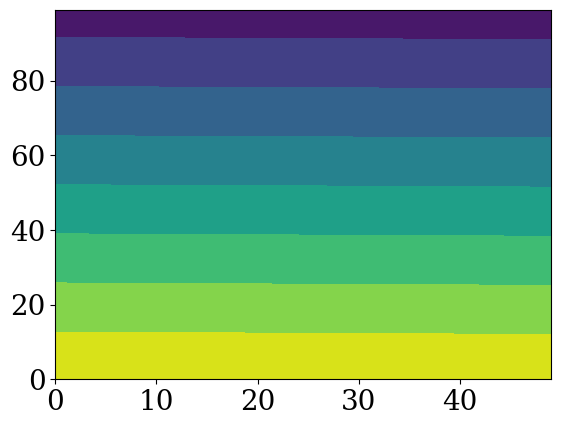

In [2]:
press_path = os.path.join(dir_name, "harvey_flow.1.out.press.pfb")
pressure = read_pfb(press_path)
header = ParflowBinaryReader(press_path).read_header()
z, dz = header["z"], header["dz"]
#hhead = compute_hydraulic_head(pressure, z, dz)
#write_pfb(os.path.join(dir_name, "harvey_flow.1.head.pfb"), hhead)

plt.contourf(pressure[:,0,:])

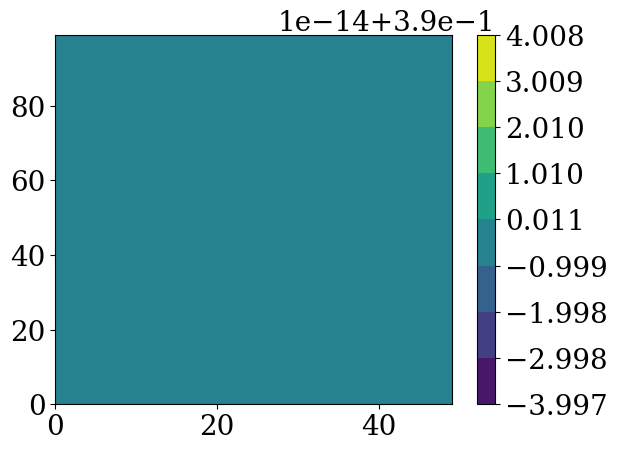

In [3]:
porosity_path = os.path.join(dir_name, "harvey_flow.1.out.porosity.pfb")
porosity      = read_pfb(porosity_path)

plt.contourf(porosity[:,0,:])
plt.colorbar()

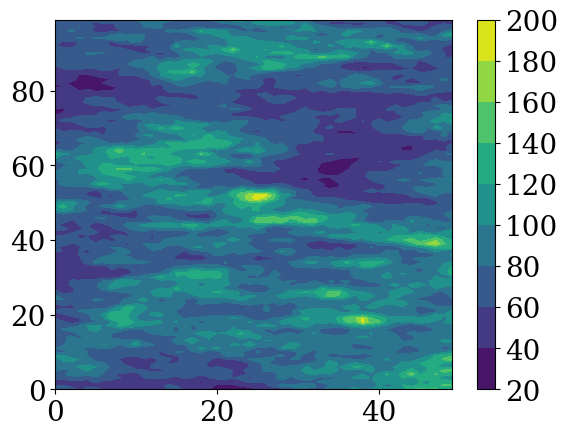

In [4]:
xpermeability_path = os.path.join(dir_name, "harvey_flow.1.out.perm_x.pfb")
xpermeability      = read_pfb(xpermeability_path)

plt.contourf(xpermeability[:,0,:])
plt.colorbar()

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 0.34, dz = 0.038
vmin: 6.1942383057589625, vmax: 9.980699869593558


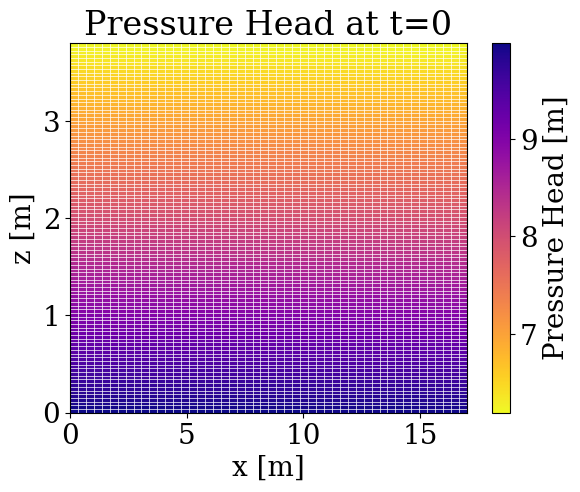

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 0.34, dz = 0.038
vmin: 0.39, vmax: 0.39


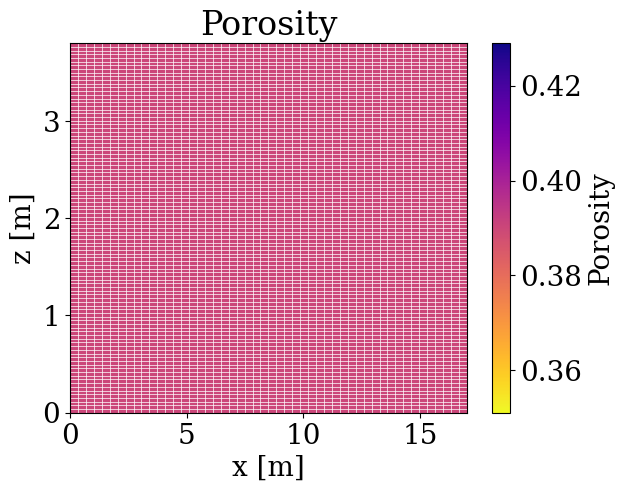

nx = 50, ny = 1, nz = 100
dx = 0.34, dy = 0.34, dz = 0.038
vmin: 31.53763551677253, vmax: 187.10155118921105


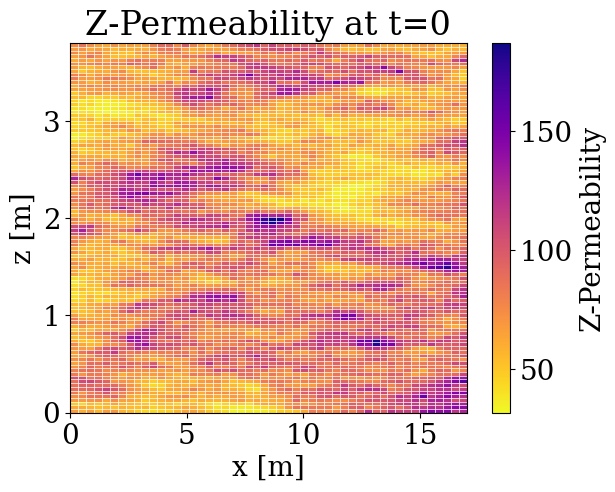

In [5]:
from plots import plot_domain_corr_rnd

plot_domain_corr_rnd(dir_name, "press", 0)
plot_domain_corr_rnd(dir_name, "porosity", 0)
plot_domain_corr_rnd(dir_name, "z-permeability", 0)

In [6]:
harvey_flow.1.out.perm_x

SyntaxError: invalid syntax (397404694.py, line 1)